# Imports

In [289]:
import os
import numpy as np
import pprint

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import pandas as pd

from timeit import default_timer as timer
import joblib

from tensorflow.keras import layers, models
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Libs options

In [41]:
#np.set_printoptions(threshold=16)
pp = pprint.PrettyPrinter(indent=4, width=90)

# Dataset

In [310]:
def list_first_val(arr):
    for i in arr:
        if i > 0:
            return 1
    return -1

def get_aabb2D(data):
    """aligned-axis bounding-box (bounding square)"""
    x1 = 0xffff
    y1 = 0xffff
    x2 = 0
    y2 = 0
    # y1
    for j in range(len(data)):
        if list_first_val(data[j]) > 0:
            y1 = j
            break
    # y2
    for j in range(len(data)):
        end = len(data)-j-1
        if list_first_val(data[end]) > 0:
            y2 = end
            break
    # x1, x2
    for j in range(len(data)):
        ydata = data[j]
        val = 0xffff
        last = 0
        for i in range(len(ydata)):
            if ydata[i] > 0:
                x1 = min(x1,i)
                x2 = max(x2,i)
    return (x1,y1, x2+1,y2+1)
    
def get_X_aabb2D(X):
    aabbs = []
    for i in range(len(X)):
        aabbs.append(get_aabb2D(X[i]))
        #if i > 10: break
    return aabbs

def read_aabb_csv(path):
    df = pd.read_csv(path)
    return list(df.itertuples(index=False, name=None))

def write_aabb_csv(X, path):
    aabb = get_X_aabb2D(X)
    df = pd.DataFrame(aabb, columns=['x1','y1','x2','y2'])
    df.to_csv(path, index=False)
    return aabb
    
def get_data():
    (X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")
    #train_test_split(self.train_index , test_size = 0.25, random_state=1)
    
    # load aabb
    if os.path.isfile('aabb_train.csv'):
        aabb_train = read_aabb_csv('aabb_train.csv')
        aabb_test = read_aabb_csv('aabb_test.csv')
        print("bounding-squares csv loaded")
    else: # or compute them (slow!)
        aabb_train = write_aabb_csv(X_train, 'aabb_train.csv')
        aabb_test = write_aabb_csv(X_test, 'aabb_test.csv')
        print("bounging-squares csv computed")
    #display(df_train)
    
    # scaling
    X_train = X_train / 255.
    X_test = X_test / 255.
    return (X_train,y_train), (X_test,y_test), (aabb_train, aabb_test)

(X_train,y_train), (X_test,y_test), (aabb_train, aabb_test) = get_data()

print("train/valid:", X_train.shape, y_train.shape)
print("test:", X_test.shape, y_test.shape)
print("aabb_train:", aabb_train[0])
print("aabb_test:", aabb_test[0])

bounding-squares csv loaded
train/valid: (60000, 28, 28) (60000,)
test: (10000, 28, 28) (10000,)
aabb_train: (4, 5, 24, 25)
aabb_test: (6, 7, 22, 27)


In [311]:
list(X_train[0][14])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3176470588235294, 0.9411764705882353, 0.9921568627450981, 0.9921568627450981, 0.4666666666666667, 0.09803921568627451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Draw image + Bounding Box

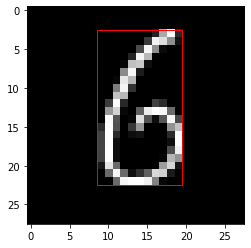

In [312]:
def plt_rectangle(tup):
    x1 = tup[0]
    y1 = tup[1]
    x2 = tup[2]
    y2 = tup[3]
    plt.gca().add_patch(Rectangle((x1-0.5,y1-0.5),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none'))
    return


idx = 18
plt.imshow(X_train[idx], cmap='gray');
plt_rectangle(aabb_train[idx])




In [316]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train[0].shape

(28, 28, 1)

# To categorical

In [317]:
y_train_cat = to_categorical(y_train, num_classes=10, dtype ="uint8")
y_test_cat = to_categorical(y_test, num_classes=10, dtype ="uint8")
print("y_train_cat.shape =",y_train_cat.shape)
print("y_test_cat.shape =", y_test_cat.shape)
pp.pprint(y_train_cat[0])

y_train_cat.shape = (60000, 10)
y_test_cat.shape = (10000, 10)
array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)


label is: Number 0


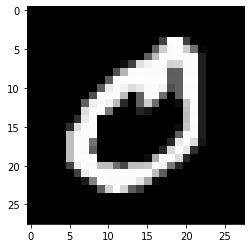

In [318]:
labels = ["Number 0",
          "Number 1",
          "Number 2",
          "Number 3",
          "Number 4",
          "Number 5",
          "Number 6",
          "Number 7",
          "Number 8",
          "Number 9"]

def categorical_to_id(arr_cat, labels=None):
    res = -1
    for i in range(len(arr_cat)):
        if arr_cat[i]:
            res = i
            break
    if labels is None:
        return res
    return labels[res]

item = 21

print("label is:", categorical_to_id(y_train_cat[item], labels))
plt.imshow(X_train[item], cmap='gray');

In [319]:
def get_model(X):
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, (4,4), activation='relu', padding='same', input_shape=X[0].shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

model = get_model(X_train)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 10)               

# Train 

In [320]:
es = EarlyStopping(patience = 5)

history = model.fit(X_train, 
                    y_train_cat,
                    validation_split = 0.3, # auto val generation
                    batch_size = 32,
                    epochs = 5,
                    callbacks = [es],
                    verbose = 1)

Epoch 1/5
1313/1313 [==============================] - 26s 19ms/step - loss: 0.3738 - accuracy: 0.8824 - val_loss: 0.1361 - val_accuracy: 0.9588
Epoch 2/5
1313/1313 [==============================] - 26s 20ms/step - loss: 0.1047 - accuracy: 0.9676 - val_loss: 0.0897 - val_accuracy: 0.9732
Epoch 3/5
1313/1313 [==============================] - 25s 19ms/step - loss: 0.0758 - accuracy: 0.9767 - val_loss: 0.0880 - val_accuracy: 0.9718
Epoch 4/5
1313/1313 [==============================] - 24s 18ms/step - loss: 0.0619 - accuracy: 0.9802 - val_loss: 0.0725 - val_accuracy: 0.9771
Epoch 5/5
1313/1313 [==============================] - 25s 19ms/step - loss: 0.0522 - accuracy: 0.9831 - val_loss: 0.0656 - val_accuracy: 0.9801


# Plot results

In [321]:
def plot_history(history, labels = ["loss"]):
    h = history.history
    with plt.style.context('seaborn-deep'):
        fig, ax = plt.subplots(1, max(2,len(labels)), figsize=(15, 4))
        x_axis = np.arange(len(h[labels[0]]))
        for i in range(len(labels)):
            l = labels[i]
            L = l.capitalize()
            ax[i].set_title(l)
            ax[i].plot(x_axis, h[l], color="blue", linestyle=":", marker="X", label="Train "+L)
            ax[i].plot(x_axis, h['val_'+l], color="orange", linestyle="-", marker="X", label="Val "+L)
            ax[i].grid(axis="x", linewidth=0.5)
            ax[i].grid(axis="y", linewidth=0.5)
            ax[i].legend()
        plt.show()

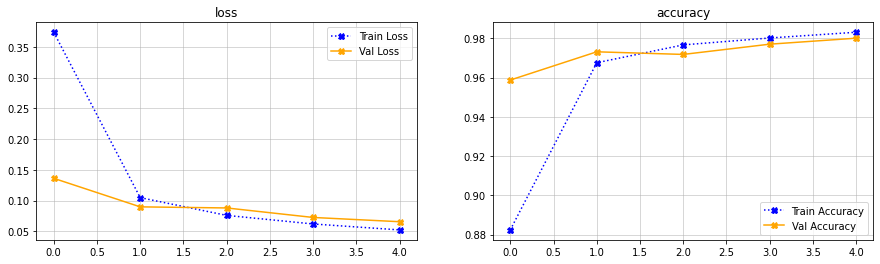

In [322]:
plot_history(history, ["loss", "accuracy"])

# Evaluation vs test set

In [323]:
res = model.evaluate(X_test, y_test_cat, verbose = 1)
print(f'The accuracy on the test set is of {res[1]*100:.2f} %')

313/313 [==============================] - 3s 8ms/step - loss: 0.0496 - accuracy: 0.9839
The accuracy on the test set is of 98.39 %


In [324]:
model.predict(X_test)

array([[2.7195664e-11, 4.5100788e-11, 6.7509951e-08, ..., 9.9995542e-01,
        4.3451712e-07, 4.9272358e-06],
       [3.7880616e-07, 4.3730188e-06, 9.9998701e-01, ..., 6.3419669e-12,
        2.4869726e-08, 2.6953037e-11],
       [4.3195026e-08, 9.9615270e-01, 3.2931461e-05, ..., 2.0923301e-06,
        2.2752873e-04, 9.2074421e-05],
       ...,
       [1.7127187e-14, 2.2018085e-08, 1.3251138e-13, ..., 3.8075090e-10,
        1.3375649e-08, 5.7241630e-07],
       [3.0317581e-06, 2.3336638e-11, 4.2378931e-10, ..., 1.6212136e-09,
        1.1674655e-04, 6.7967541e-08],
       [1.9134927e-06, 1.4431660e-11, 9.9315187e-09, ..., 1.0036777e-14,
        4.8844129e-07, 3.4651548e-06]], dtype=float32)

# Predict one observation

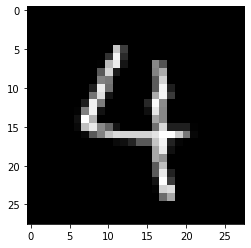

Prediction is = Number 4 (100.00%)


In [329]:
label = 2

predicted = list(model.predict(np.array([X_test[label]]))[0])
#print("prediction table:", predicted)
plt.imshow(X_test[label], cmap='gray')
plt.show()

predicted_label = labels[predicted.index(max(predicted))]
print("Prediction is =", predicted_label, f"({max(predicted)*100:.2f}%)")

# Class Scores

In [182]:
print(f"Prediction table for '{predicted_label}':")
print("\n",predicted)

Prediction table for 'Number 1':

 [0.00021510555, 0.99914587, 0.00042324836, 3.05158e-08, 3.9256654e-05, 5.286392e-12, 2.3547776e-13, 5.5486765e-07, 0.00017592404, 2.5604643e-09]


# Save

In [184]:
joblib.dump(model, f'model_digits.joblib')

2023-04-17 23:41:11.560063: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e402c9da-5e2d-4386-a46d-728e1e9d7dd5/assets


['model_digits.joblib']